# Believer-Skeptic meets Actor-Critic

In [49]:
from __future__ import division
import ADMCode
from ADMCode import visualize as vis
# from ADMCode import 

import numpy as np
from numpy.random import sample as rs
import pandas as pd
import sys
import os

# from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Temporary for now until push changes to PIP 
sys.path.insert(0,'../ADMCode')
import believer_skeptic

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

## Believer-Skeptic model

Recall from the previous lecture that the Believer Skeptic model posits that decisions arise from the competitive architecture of the cortico-basal ganglia thalamus (CBGT) pathways. The critical assumptions of the model are:

* CBGT pathways are organized as action channels.
* Within-channel competition between the direct (Believers) and indirect (Skeptic) pathways map to the accumulation rate of the decision for an action channel.
* Greater within-channel competition slows the accumulation of evidence for the specific decision.
* Hyper-direct pathways act as a global emergency break.
* For multi-choice decisions, the first accumulation process to hit its decision boundary wins.


In [50]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url='images/believer-skeptic.png', width=500)

In [51]:
Image(url='images/believer-skeptic_to_accumulation.png', width=500)

## Iowa Gambling Task (IGT)

The IGT is a popular neuropsychology task that looks at strategic decision-making. Get the most points possible after a specific number of draws from four decks. Participants can only pull from one deck at a time. Two decks (C & D) are advantageous, meaning that they'll pay off in the long run. Two decks are disadvantageous (A & B) meaning that you will lose in the long run if you select from these decks.

In [52]:
Image(url='images/IGT.png', width=500)

In [53]:
homedir = os.path.expanduser('~')
igtData = pd.read_csv(os.path.join("../data/IGTCards.csv"))

## Parameter definitions

**$v_d$** : drift rate of the direct (Go) pathway

**$v_i$** : drift rate of the indirect (Go) pathway

**$a$**   : boundary height (of the $v_d-v_i$ process)

**$tr$**  : non-decision time

**$\gamma$ or $xb$**  : exponential term on the $v_d-v_i$ process

**$\alpha^G$ or $aGo$** : learning rate on the direct (Go) pathway

**$\alpha^N$ or $aNo$** : learning rate on the indirect (NoGo) pathway

## Diffusion & update equations

The Go (G; direct pathway) and NoGo (N; indirect pathway) processes on each trial $t$ are simulated for every $j$ action channel at each timestep $\tau$ $(\Delta \tau = 1ms)$ as:

$G_{j,t}(\tau) = G_{j,t}(\tau - \Delta \tau) + \upsilon ^G _{j,t} \Delta \tau + \epsilon^G_j (\tau)$

$N_{j,t}(\tau) = N_{j,t}(\tau - \Delta \tau) + \upsilon ^N _{j,t} \Delta \tau + \epsilon^N_j (\tau)$

where $G_{j,t}(\tau - \Delta \tau)$ and $N_{j,t}(\tau - \Delta \tau)$ are the state of the processes at the previous update. 

$\epsilon^{G/N}_j (\tau)$ represents the diffusion noise at each update as a normal distribution (i.e., $\epsilon^{G/N}_j (\tau) ~ N(0,\sigma^2)$).

Finally the action value for each channel and each pathway is reflected by the $\upsilon^{G/N}_{j,t}$ terms for the $j^{th}$ action on trial $t$.

<br>

### The execution process

The execution process $\theta$ for each action channel $j$ is then computed in the network output layer as teh difference between the $G$ and $N$ processes.

$\theta_{j,t}(\tau) = [G_{j,t}(\tau) - N_{j,t}(\tau)] \cdot cosh(\gamma \cdot \tau)$

Where $cosh(\gamma \cdot \tau)$ is an exponential term where the drift process accelerates to the decision boundary as time progresses.

<br>

### The learning process

At the end of the simulated trial a reward signal $r(t)$ is given, reflecting the value of the card selected. We then update the value of each target deck $q_j$ as

$q_j(t+1) = q_j(t) + \alpha \cdot [r(t) - q_j(t)]$.

To implement this as a learning rule, we $q_j$ to estimate softmax probability of selecting each deck $j$.

$p_j(t) = \frac{\exp{\beta \cdot q_j(t)}}{\Sigma^n_i \exp{\beta \cdot q_i(t)}}$

As usual, $\beta$ is the inverse temperature paremeter. We will assume that it is held constant, but will use the probability of selecting each deck (i.e., the probability of each action $j$) to update the action values which, in turn, impact the selection "policy" by the drift process. Specifically, we can now estimate the reward prediction error ($\delta$) on each trial as the difference in selection procbability from the previous trial (which is updated by $r(t)$).

$\delta_j(t) = p_j(t) - p_j(t-1)$

Using $\delta_j(t)$ we can then update the value functions for the $G$ and $N$ processes as

$\upsilon^G_{j,t+1} = \upsilon^G_{j,t} + \alpha^G \cdot \delta_j(t)$

$\upsilon^N_{j,t+1} = \upsilon^N_{j,t} + \alpha^N \cdot \delta_j(t)$

Here $\alpha^G$ and $\alpha^N$ are the learning rates for the Go (G) and NoGo (N) procecesses.


For the purposes here, we want to simulate four action channels that race to be the first to make a decision

In [54]:
Image(url='images/multichannel_selection.png', width=700)

## Performing the IGT with a 4-choice believer-skeptic model

In [55]:
# Define the DDM parameters as an object to pass
p={'vd':np.asarray([.7]*4), 'vi':np.asarray([.25]*4), 'a':.25, 'tr':.3, 'xb':.00005}
p

{'a': 0.25,
 'tr': 0.3,
 'vd': array([ 0.7,  0.7,  0.7,  0.7]),
 'vi': array([ 0.25,  0.25,  0.25,  0.25]),
 'xb': 5e-05}

## Implementing learning in the Believer-Skeptic network

(insert learning equations here)

In [56]:
# Learning rates on the Go (direct) and NoGo (indirect) pathways
aGo=.1
aNo=.1

In [57]:
# Now run one simulation of the IGT with the believer-skeptic model
# With singleProcess==0, we are approximating the direct-indirect competition
# on each run by simulating a single process based on the difference in the 
# two drift rates
homedir = os.path.expanduser('~')
igtData = pd.read_csv(os.path.join("../data/IGTCards.csv"))

outdf, agentdf = believer_skeptic.play_IGT(p, feedback=igtData, beta=.09, nblocks=2, 
                          alphaGo=aGo, alphaNo=aNo, singleProcess=0)

In [58]:
# Look at the selection rate of our simulated agent
# 0 = Deck A
# 1 = Deck B
# 2 = Deck C
# 3 = Deck D

print(agentdf.rt.mean())
agentdf.iloc[:, :].choice.value_counts().sort_index()

0.64002


0.0    18
1.0    16
2.0    24
3.0    42
Name: choice, dtype: int64

Let's look at the within-channel competition (direct-indirect) $V_{\Delta}$ for each action channel.

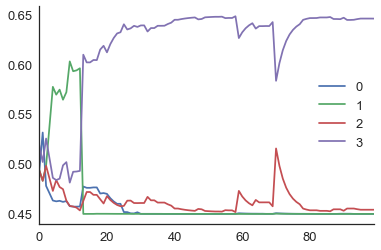

In [59]:
_=[agentdf['vDelta{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

We can see how this competition emerges by looking at the separate drift rates for the direct ($v_d$) & indirect ($v_i$) pathways.

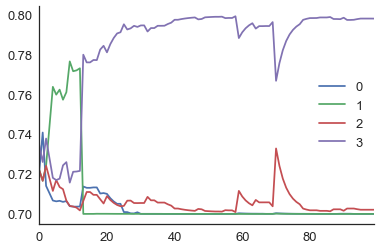

In [60]:
_=[agentdf['vd{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

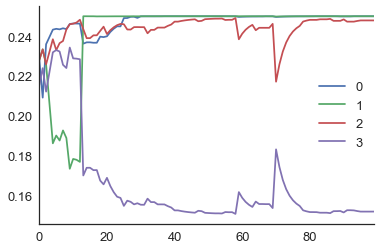

In [61]:
_=[agentdf['vi{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

Next let's look at the q-value for each action.


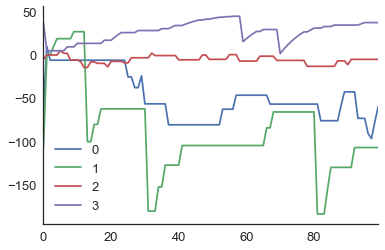

In [62]:
_=[outdf['q{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

Next let's look at the action policy (i.e. $\beta$).

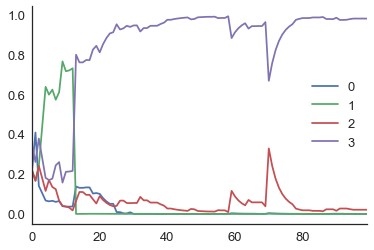

In [63]:
_=[outdf['p{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

In [64]:
# Take another look at our parameters
p

{'a': 0.25,
 'tr': 0.3,
 'vd': array([ 0.70001539,  0.70000021,  0.70209838,  0.79788602]),
 'vi': array([ 0.24998461,  0.24999979,  0.24790162,  0.15211398]),
 'xb': 5e-05}

For simplicity sake we modeled the competitive process as a dual process, but you can also run the full competition model (it's just slower). Here's how that foramlly works.

In [65]:
# This is a snippet from believer_skeptic.py, specifically the 
# simulate_multirace function.
single_process=0 
si=.1
tb=1.0
dt=.001
nresp = p['vd'].size
dx = si * np.sqrt(dt)
nTime = np.ceil((tb-p['tr'])/dt).astype(int)
xtb = believer_skeptic.temporal_dynamics(p, np.cumsum([dt]*nTime))

# Run the process model
Pd = .5 * (1 + (p['vd'] * np.sqrt(dt))/si)
Pi = .5 * (1 + (p['vi'] * np.sqrt(dt))/si)
direct = xtb * np.where((rs((nresp, nTime)).T < Pd),dx,-dx).T
indirect = np.where((rs((nresp, nTime)).T < Pi),dx,-dx).T
execution = np.cumsum(direct-indirect, axis=1)

act_ix, rt, rt_ix = believer_skeptic.analyze_multiresponse(execution, p)    

nsteps_to_rt = np.argmax((execution.T>=p['a']).T, axis=1)
rts = p['tr'] + nsteps_to_rt*dt

# set non responses to 999
rts[rts==p['tr']]=999


0


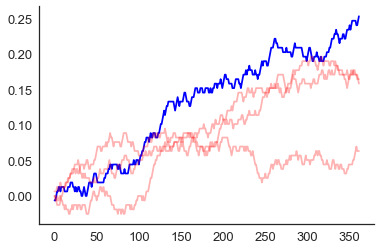

In [66]:
# get accumulator with fastest RT (winner) in each cond
act_ix = np.argmin(rts)
winner, rt=act_ix, rts[act_ix]
rt_ix = np.ceil((rt-p['tr'])/dt).astype(int)
actions = np.arange(nresp)
losers = actions[actions!=act_ix]
print(act_ix)
plt.plot(execution[act_ix][:rt_ix], color='b')
for l in losers:
    plt.plot(execution[l][:rt_ix], color='r', alpha=.3)
sns.despine()